In [16]:
import math
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

In [12]:
class market_position_record_hist(object):
    def __init__(self, sigma, ell, v=0.01):
        '''Initialize the simulator, v is the spread, we assume it is constant for now.'''

        # constant parameters
        self.sigma = sigma
        self.ell = ell
        self.dt = 1
        self.spread = v
        self.transaction_p = 0.7
        self.inventory_limit = 100
        self.reverse_selection_factor = 0.0001

        # list to contain historical movements of variables
        self.value = [10000]
        self.hist_x = [10]
        self.hist_bid = [9.75]
        self.hist_ask = [10.25]
        self.hist_q = [0]
        self.hist_cash = [10000]
        #initial_skew = findMaxSkew(self.mu, self.sigma, self.hist_x[-1], self.ell, self.hist_cash[-1], self.hist_q[-1], self.spread, self.dt)
        initial_skew = 0.5
        self.hist_skew = [initial_skew]
        self.Pbuy = [initial_skew]

    def __repr__(self):
        '''Representation'''
        result = ""
        result += "Final stock price is: " + str(self.hist_x) + "\n"
        result += "Final inventory is: " + str(self.hist_q[-1]) + "\n"
        result += "Final cash account is: " + str(self.hist_cash[-1]) + "\n"
        result += "Final P&L is: " + str(self.value[-1])
        return result
    
    def set_skew(self, skew):
        '''Set a new skewness of bid ask spread'''
        self.hist_skew.append(skew)

    def get_accumulated_value(self, t):
        '''Show hist P&L'''
        return self.value
    
    def transaction_coming(self):
        '''Return True as a transaction has arrived, return False as no transaction coming.'''
        return np.random.binomial(1, self.transaction_p) == 1
    
    def buy_sell(self):
        '''Return True as buy transaction, return False as sell transaction'''
        return np.random.binomial(1, self.Pbuy[-1]) == 1
    
    def new_stock_price(self):
        '''Return stock price change as a geometric brownian motion'''
        return self.hist_x[-1] * math.exp((-1 * (self.sigma ** 2) / 2) * self.dt + self.sigma * np.random.normal() * math.sqrt(self.dt))
    
    def simulate_one_3tree(self):
        '''Simulate one time foreward. This method simulated stock price in 3 branches tree'''
        # simulate incoming transaction, if there is, adjust inventory and cash account
        transaction = self.transaction_coming()
        buy = self.buy_sell()
        if self.transaction_coming() and buy and self.hist_q[-1] <= self.inventory_limit:
            self.hist_q.append(self.hist_q[-1] + 1)
            self.hist_cash.append(self.hist_cash[-1] - self.hist_bid[-1])
            self.hist_x[-1] = self.hist_x[-1] * (1 - self.reverse_selection_factor)
        elif self.transaction_coming() and (not buy) and self.hist_q[-1] >= (-1 * self.inventory_limit):
            self.hist_q.append(self.hist_q[-1] - 1)
            self.hist_cash.append(self.hist_cash[-1] + self.hist_ask[-1])
            self.hist_x[-1] = self.hist_x[-1] * (1 + self.reverse_selection_factor)
        else:
            self.hist_q.append(self.hist_q[-1])
            self.hist_cash.append(self.hist_cash[-1])

        self.hist_x.append(self.new_stock_price())
        
        self.value.append(self.hist_q[-1] * self.hist_x[-1] + self.hist_cash[-1])
        
        new_skew = findMaxSkew(self.sigma, self.hist_x[-1], self.ell, self.hist_cash[-1], self.hist_q[-1], self.spread, self.dt)
        self.hist_skew.append(new_skew)
        self.Pbuy.append(self.hist_skew[-1])
        self.hist_ask.append(self.hist_x[-1] + self.spread * (3 / 2 - 2 * self.hist_skew[-1]))
        self.hist_bid.append(self.hist_x[-1] + self.spread * (1 / 2 - 2 * self.hist_skew[-1]))
        
    def n_simulate(self, n):
        '''simulate n steps'''
        for i in range(n):
            self.simulate_one_3tree()
            if self.Pbuy[-1] < 0:
                break
            if self.value[-1] < -1 * self.ell:
                break


In [13]:
def findMaxSkew(sigma,x,ell,cash,Q,vx,dt):
    return 0.5

Asset Price


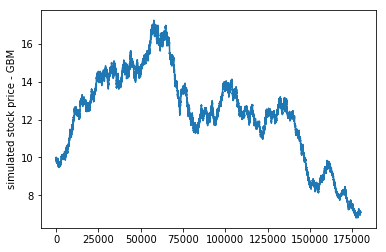

P&L


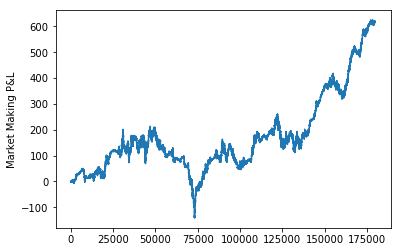

Inventory


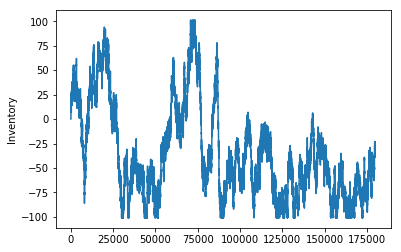

Skew of spread


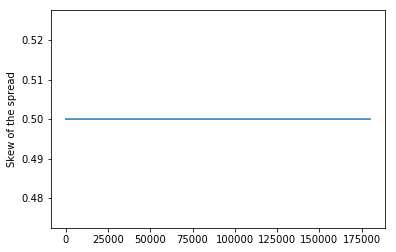

Time used:  5.853847999999999


In [17]:
if __name__ == "__main__":
    tic = time.clock()
    result = []

    a = market_position_record_hist(0.001, 1000)
    a.n_simulate(180000) # 1800000 seconds is about 3 months trading time

    df = pd.DataFrame()
    df['skew'] = a.hist_skew
    df['price'] = a.hist_x
    df['bid'] = a.hist_bid
    df['ask'] = a.hist_ask
    df['inventory'] = a.hist_q
    df['cash'] = a.hist_cash
    df['P&L'] = np.array(a.value) - 10000
    df['Prob_Buy'] = a.Pbuy
    
    print("Asset Price")
    plt.plot(a.hist_x)
    plt.ylabel('simulated stock price - GBM')
    plt.show()

    print("P&L")
    plt.plot(df['P&L'])
    plt.ylabel('Market Making P&L')
    plt.show()

    print("Inventory")
    plt.plot(df['inventory'])
    plt.ylabel('Inventory')
    plt.show()

    print("Skew of spread")
    plt.plot(df['skew'])
    plt.ylabel('Skew of the spread')
    plt.show()

    result.append(a.value[-1])
        
    toc = time.clock()
    print('Time used: ', toc - tic)